# Emulating cosmic shear covariances

Cosmic shear is the correlation of shapes of galaxies separated by some distance on the sky. The correlation of galaxies aligned with each other is designated by $\xi_+$. In this notebook, we will build an emulator for $\xi_+$ from a set of 25 covariances computed by Tim Eifler in a 6 dimensional parameter space (cosmology galaxy bias).

In [1]:
import numpy as np
import covariance_emulator
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
plt.rc("font", size=14, family="serif")
#plt.rc("text", usetex=True)

In [3]:
#Read in the domain locations, or locations in parameter space
parameters = np.loadtxt("cosmo_parameters.txt")[:, :6] #Remove parameters that are irrelevent here
print(parameters.shape)

(25, 6)


In [4]:
#Load in the covariances
covs = np.load("tomo0_sub_covs.npy")
print(covs.shape)

(25, 20, 20)


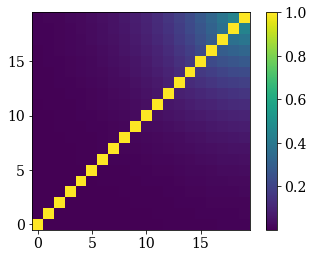

In [5]:
#View the correlation matrix of the first
def corr_from_cov(cov):
    D = np.diag(np.sqrt(cov.diagonal()))
    Di = np.linalg.inv(D)
    return np.dot(Di, np.dot(cov, Di))

def view_corr(cov, lncov=False):
    R = corr_from_cov(cov)
    fig, ax = plt.subplots()
    if lncov:
        R = np.log(np.fabs(cov))
    im = ax.imshow(R, interpolation="nearest", origin="lower")
    plt.colorbar(im)
    return

view_corr(covs[0])

In [6]:
#Split off the last covariance matrix
test_cov = covs[-1]
test_parameters = parameters[-1]
covs = covs[:-1]
parameters = parameters[:-1]

In [7]:
#Create an emulator
Emu = covariance_emulator.CovEmu(parameters, covs, NPC_D=6, NPC_L=6)
#Predict
print(test_parameters.shape)
Cpredicted = Emu.predict(test_parameters)

(6,)


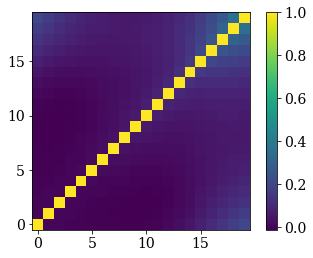

In [8]:
#View the test covariance matrix
view_corr(Cpredicted)

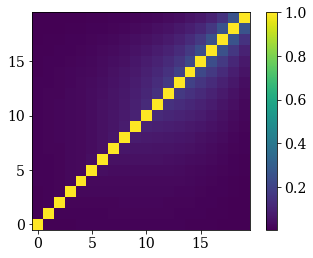

In [9]:
#View the test covariance matrix
view_corr(test_cov)

In [10]:
#Define a function to pull out just the off-diagonals and compute the fractional differences
def get_fracdiff_in_offdiag(C1, C2, ndim):
    D = C1 - C2
    out = np.zeros(int(ndim*(ndim-1)/2))
    k = 0
    for i in range(1,ndim):
        for j in range(0,i):
            out[k] = D[i,j]/C1[i,j]
            k+=1
    return out

In [11]:
diff = test_cov - Cpredicted
print("Mean fractional differences in off-diagonals:")
fracdiffs = get_fracdiff_in_offdiag(test_cov, Cpredicted, len(test_cov))
print(np.mean(fracdiffs), np.min(fracdiffs), np.max(fracdiffs))
print("Fractional differences in diagonals:")
print(diff.diagonal()/test_cov.diagonal())
print(np.mean(diff.diagonal()/test_cov.diagonal()))

Mean fractional differences in off-diagonals:
(-2.475443364508012, -94.92273764042955, 1.7514987356529375)
Fractional differences in diagonals:
[ 0.01188944  0.01301272  0.0143583   0.01590923  0.01773193  0.01999277
  0.02290925  0.0267575   0.03205685  0.03951627  0.04946358  0.0620935
  0.07650675  0.09030711  0.09965068  0.09782536  0.07962525  0.04420824
 -0.00341158 -0.0562972 ]
0.03770529769677685


It appears that the diagonals are predicted to about 4% accuracy, and the off diagonals are less accurate, but very small.